<a id='1'></a>
<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

# Обзор

<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

**Стратегия это - функция для открытия и закрытия позиций созданная из индикатора**.  Например, если у вас есть индикатор, отображающий пересечение скользящих средних, вы можете превратить его в стратегию, добавив команды strategy.entry для входа и strategy.close для выхода из позиций. 
т.е. по сути это индикатор или комплекс индикаторов заключенной в одной функции.

<p style = "background-color : #afeeee; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">Импортируем библиотеки используемые в работе:</span>

In [53]:
# Расчёты
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Для распечатки в цвете:
from termcolor import colored

from sklearn.preprocessing import MinMaxScaler

import re
# import nltk
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
from collections import Counter

<p style = "background-color : #afeeee; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">Функции:</span>

<p style = "background-color : #95f59ff2; border-radius: 5px 5px; padding : 5px"><strong>
<span style="color:#000">Графики</span>

In [54]:
def build_graph(library, chart_type, data_frame, x, y, height, width, title, xaxis_title, yaxis_title, legend = None, color = None):
    """Функция по построению графиков

    Args:
        library: Библиотека построения
        chart_type: Тип графика
        data_frame: Датафрейм из которого будет читаться данные
        x: Ось x
        y: Ось y
        height: Высота графика
        width: Ширина графика
        title: Название графика
        xaxis_title: Название оси x
        yaxis_title: Название оси y
        legend: Название легенды
        color: Цвет колонок
    Raises:
        ValueError: Ошибка вызова графика
    """
    if library == 'plt':
        plt.figure(figsize=(height, width))
        plt.title(title)
        if chart_type == 'box':
            sns.boxplot(data=data_frame, x=x, y=y)
        elif chart_type == 'bar':
            sns.barplot(data=data_frame, x=x, y=y)
        else:
            raise ValueError("Неподдерживаемый тип графика. Допустимые значения chart_type: 'box', 'bar'")
        plt.xlabel(xaxis_title)
        plt.ylabel(yaxis_title)
        plt.show()
    # plotly
    elif library == 'px':
        if chart_type == 'box':
            fig = px.box(data_frame=data_frame, x=x, y=y, color=color, title=title)
        elif chart_type == 'bar':
            fig = px.bar(data_frame=data_frame, x=x, y=y, color=color, title=title)
        else:
            raise ValueError("Неподдерживаемый тип графика. Допустимые значения chart_type: 'box', 'bar'")
        
        fig.update_layout(
            title=dict(x=0.5, xanchor="center"),
            legend_title=legend,
            xaxis_title=xaxis_title,
            yaxis_title=yaxis_title,
            margin=dict(l=0, r=0, t=30, b=0),
            title_x=0.5
        )
        fig.show()
    else:
        raise ValueError("Неподдерживаемая библиотека. Допустимые значения library: 'px', 'plt'")


In [55]:
def pie_graph(data, title_text):
    # Построение круговой диаграммы
    fig = go.Figure(
        data=[go.Pie(       
            values=data.values, 
            labels=data.index, 
            pull=[0.1]*len(data)
        )]
    )


    fig.update_traces(
        hoverinfo='label+value',  # Добавляем информацию при наведении
        textinfo='percent',
        textfont_size=15,
        marker=dict(line=dict(color='#000000', width=2))
    )

    # Устанавливаем название графика и размеры текста:
    fig.update_layout(
        title_text=title_text,
        title_font_size=20,
        legend_font_size=20,
        width=800,
        height=600
    )

    fig.show()

In [56]:
def gist_graph(df, column, title):    
    # Вычисляем моду, это понадобится для выделение моды на графике
    sharpe_mode = df[column].mode()[0]

    fig = px.histogram(
        df,   
        x = column,
        marginal='box',
        nbins=200,
        width=1000,
        height=500,
        color_discrete_sequence=['Orangered']
    )

    # Устанавливаем название графика, размеры текста и наименование осей:
    fig.update_layout(
        title={
            'text': title,
            'y':0.97,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
            },
        title_font={
            'size':18,
            'color':"black"
            },
        xaxis_title='Размер коэффициента',
        yaxis_title='Количество вхождений'
    )

    # Добавляем обводку колонок
    fig.update_traces(
        hoverinfo="all",
        hovertemplate="Диапазон размера коэффициента: %{x}",
        marker_line_color='black',   # Цвет линии колонки
        marker_line_width=1.0,       # Толщина линии колонки
        opacity=0.9            # Прозрачность колонки
    )

    # Устанавливаем дополнительную линию моды на графике:
    fig.add_vline(
        x=sharpe_mode,
        line_width=2, 
        line_color="black", 
        annotation_text=f"Мода распределения: {sharpe_mode}",
        annotation_position='bottom left'
    )

    fig.update_xaxes(showspikes=True)
    fig.update_yaxes(showspikes=True)
    fig.show()

<p style = "background-color : #95f59ff2; border-radius: 5px 5px; padding : 5px"><strong>
<span style="color:#000">Работа с текстом</span>

In [57]:
# Функция для очистки текста
def clean_text(text):
    # Удаление эмодзи и спецсимволов, кроме пробелов
    text = re.sub(r'[^\w\s]', '', str(text))
    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip().lower()
    return text

In [58]:
def classify_tags(row, tags_dict):
    """Функция для классификации тегов на основе нового словаря."""
    text_to_analyze = f"{str(row['strategy_description'])} {str(row['tags'])}"
    classifications = []

    for category, keywords in tags_dict.items():
        if any(re.search(r'\b' + re.escape(keyword) + r'\b', text_to_analyze) for keyword in keywords):
            classifications.append(category)

    # Если найдено более одного тега, возвращаем 'mixed' УБРАТЬ ЭТУ СТРОКУ ЕСЛИ НАМ НЕОБХОДИМЫ ВСЕ ВХОЖДЕНИЯ
    if len(classifications) > 1:
        return 'combined strategy'
    
    return classifications[0] if classifications else 'No classification'

In [59]:
def check_keywords(df, tags):
    """Функция для проверки наличия ключевых слов в датафрейме."""
    # Объединяем описание и теги
    df['combined'] = (df['strategy_description'].fillna('') + ' ' + df['tags'].fillna('')).str.lower()
    
    # Функция для обработки каждой строки
    def process_text(text):
        matched_tags = []
        for keyword in tags:
            if keyword in text:
                matched_tags.append(keyword)
        return matched_tags

    # Применяем функцию к объединенному тексту
    df['type_tags'] = df['combined'].apply(process_text)
    return df.drop(columns=['combined'])

In [60]:
def convert_to_numeric(val):
    # Проверяем, является ли значение строкой
    if isinstance(val, str):
        # Заменяем символы и удаляем пробелы
        val = val.replace('−', '-')  # Заменяем минус на стандартный
        val = val.replace('+', '')    # Удаляем знак плюс
        val = val.replace(',', '')     # Удаляем запятые
        # Проверяем, содержит ли значение знак процента
        if '%' in val:
            val = val.replace('%', '')  # Удаляем знак процента
            val = val.strip()            # Удаляем пробелы по краям
            # Преобразуем строку в числовой формат и делим на 100 для получения десятичного значения
            return pd.to_numeric(val, errors='coerce') / 100
    # Если значение уже числовое, просто возвращаем его
    return val if isinstance(val, (int, float)) else pd.to_numeric(val, errors='coerce')


In [61]:
# def convert_to_numeric(val):
#     # Заменяем символы и удаляем пробелы
#     val = val.replace('−', '-')  # Заменяем минус на стандартный
#     val = val.replace('+', '')    # Удаляем знак плюс
#     val = val.replace(',', '')     # Удаляем запятые
#     val = val.replace('%', '')     # Удаляем проценты
#     return pd.to_numeric(val, errors='coerce')  # для преобразования строки в числовой формат, при этом errors='coerce' заменяет некорректные значения на NaN.

<p style = "background-color : #95f59ff2; border-radius: 5px 5px; padding : 5px"><strong>
<span style="color:#000">Создание датафреймов</span>

In [62]:
def process_tags(df, tags_dict):
    """Функция по созданию датафреймов согласно списку тегов."""
    tag_counts_results = {}

    for tag_name, keywords in tags_dict.items():
        # Проверяем ключевые слова из ранее сделанной функции
        filtered_df = check_keywords(df, keywords)
        # Убираем строки с пустыми классификациями
        filtered_df = filtered_df[filtered_df['type_tags'].apply(lambda x: x != [])]
        # Сохраняем только нужные столбцы
        filtered_df = filtered_df[['title', 'type_tags']]
        
        # Разбиваем списки на отдельные строки
        exploded_tags = filtered_df.explode('type_tags')
        
        # Подсчитываем количество вхождений каждого тега
        tag_counts = exploded_tags['type_tags'].value_counts().reset_index()
        tag_counts.columns = ['tag', 'count']  # Переименовываем колонки
        
        # Сортируем по количеству вхождений
        tag_counts = tag_counts.sort_values(by='count', ascending=False)
        
        # Сохраняем результат в словаре
        tag_counts_results[tag_name] = tag_counts

    return tag_counts_results


<a id='1'></a>
<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

# Обзор колонок датасета

<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

<div class="alert alert-info">

##### **Overview (Обзор)**
- <span style="color:#af0400">**title**</span> -  <span style="color:#02020A">**Название стратегии**</span>;
- <span style="color:#af0400">**strategy_description**</span> - <span style="color:#02020A">**Описание стратегии**</span>;
- <span style="color:#af0400">**tags**</span> - <span style="color:#02020A">**Теги к стратегии**</span>;

##### **Performance (Отчет о стратегии)**
- <span style="color:#af0400">**Open P&L**</span> - <span style="color:#02020A">**Анализ сделок**</span> (Прибыль или убыток по текущей открытой позиции. Если позиция не открыта, возвращается значение N/A)</span>;
- <span style="color:#af0400">**Net profit**</span> - <span style="color:#02020A">**Чистая прибыль**</span> (Значение представляет собой сумму всех значений из столбца «Прибыль»);
- <span style="color:#af0400">**Gross profit**</span> - <span style="color:#02020A">**Валовая прибыль**</span> (Общая прибыль по всем прибыльным сделкам, генерируемая стратегией);
- <span style="color:#af0400">**Gross loss**</span> - <span style="color:#02020A">**Валовый убыток**</span> (Общие убытки по всем убыточным сделкам, совершенным по стратегии. Анализ и сокращение торговых убытков — чрезвычайно важная часть анализа торговой стратегии. Именно поэтому эта характеристика стратегии является наиболее важной. Следует отметить, что чистая прибыль увеличивается не только при увеличении валовой прибыли, но и при сокращении валовых убытков);
- <span style="color:#af0400">**Commission paid**</span> - <span style="color:#02020A">**Уплаченная комиссия**</span>;
- <span style="color:#af0400">**Buy & hold returntact**</span> - <span style="color:#02020A">**Возврат средств при покупке и удержании**</span> (Доходность, полученная в случае, если все средства (начальный капитал) были использованы для покупки ценной бумаги при открытии первой сделки и позиция удерживалась в течение всего тестового периода);
- <span style="color:#af0400">**Max equity run-up**</span> - <span style="color:#02020A">**Максимальный прирост собственного капитала**</span> (Отображает максимальный выигрыш, то есть максимально возможный выигрыш, который стратегия могла бы получить по всем совершённым сделкам);
- <span style="color:#af0400">**Max equity drawdown**</span> - <span style="color:#02020A">**Максимальная просадка собственного капитала**</span> (Отображает наибольшую просадку по убыткам, то есть максимально возможный убыток, который могла бы понести стратегия по всем совершённым сделкам.);
- <span style="color:#af0400">**Max contracts held**</span> - <span style="color:#02020A">**Максимальное количество заключенных контрактов**</span> (Максимальное количество контрактов, заключенных одновременно.).


##### **Trades analysis (Анализ сделок)**
- <span style="color:#af0400">**Total trades**</span> - <span style="color:#02020A">**Общее количество сделок**</span> (как выигрышных, так и убыточных);
- <span style="color:#af0400">**Total open trades**</span> - <span style="color:#02020A">**Общее количество открытых сделок**</span> (в данный момент);
- <span style="color:#af0400">**Winning trades**</span> - <span style="color:#02020A">**Выигрышные сделки**</span>;
- <span style="color:#af0400">**Losing trades**</span> - <span style="color:#02020A">**Убыточные сделки**</span>;
- <span style="color:#af0400">**Percent profitable**</span> - <span style="color:#02020A">**Процент прибыльности**</span> (Процент прибыльных сделок, совершённых по стратегии. Рассчитывается путём деления количества прибыльных сделок на общее количество закрытых сделок, совершённых по стратегии. Процент прибыльных сделок сам по себе не является надёжным показателем);
- <span style="color:#af0400">**Avg P&L**</span> - <span style="color:#02020A">**Средний доход за год**</span> (Сумма денег, полученная или потерянная в результате средней сделки, заключённой по стратегии. Рассчитывается путём деления чистой прибыли на общее количество закрытых сделок. Важное значение, поскольку оно должно быть достаточно большим, чтобы покрыть комиссию и издержки, связанные с проскальзыванием, и при этом приносить прибыль);
- <span style="color:#af0400">**Avg winning trade**</span> - <span style="color:#02020A">**Средняя выигрышная сделка**</span> (Валовая прибыль, делённая на количество прибыльных сделок, совершённых по стратегии);
- <span style="color:#af0400">**Avg losing trade**</span> - <span style="color:#02020A">**Средняя убыточная сделка**</span> (Общий убыток, делённый на количество убыточных сделок, открытых по стратегии);
- <span style="color:#af0400">**Ratio avg win / avg loss**</span> - <span style="color:#02020A">**Соотношение avg выигрыш / avg проигрыш**</span> (Среднее значение того, сколько денежных единиц вы выигрываете на каждую потерянную единицу (в выбранной валюте). Это значение рассчитывается путём деления среднего количества выигрышных сделок на среднее количество проигрышных сделок. Само по себе это поле не является очень значимым, поскольку оно не учитывает соотношение количества выигрышных и проигрышных сделок, а стратегии могут иметь разные подходы к прибыльности);
- <span style="color:#af0400">**Largest winning trade**</span> - <span style="color:#02020A">**Самая крупная выигрышная сделка**</span> (Наибольшая денежная прибыль и наибольшая процентная прибыль. Эти показатели обычно относятся к одной и той же сделке, но могут относиться и к разным сделкам);
- <span style="color:#af0400">**Largest winning trade percent**</span> - <span style="color:#02020A">**Процент самой крупной выигрышной сделки**</span>;
- <span style="color:#af0400">**Largest losing trade**</span> - <span style="color:#02020A">**Самая убыточная сделка**</span>;
- <span style="color:#af0400">**Largest losing trade percent**</span> - <span style="color:#02020A">**Процент самой убыточной сделки**</span>(Наибольшая денежная потеря и наибольшая процентная потеря. Эти показатели обычно относятся к одной и той же сделке, но могут относиться и к разным сделкам);
- <span style="color:#af0400">**Avg # bars in trades**</span> - <span style="color:#02020A">**Среднее количество в баров сделок**</span>;
- <span style="color:#af0400">**Avg # bars in winning trades**</span> - <span style="color:#02020A">**Среднее количество в баров в выигрышных сделках**</span>;
- <span style="color:#af0400">**Avg # bars in losing trades**</span> - <span style="color:#02020A">**Среднее количество в баров убыточных сделках**</span>;
 
##### **Risk / performance ratios (Соотношения риска и доходности)**
- <span style="color:#af0400">**Sharpe ratio**</span> - <span style="color:#02020A">**Коэффициент Шарпа**</span> (Чем выше коэффициент Шарпа, тем более плавная кривая доходности. Для многих трейдеров плавная кривая доходности является важной целью);
- <span style="color:#af0400">**Sortino ratio**</span> - <span style="color:#02020A">**Коэффициент Сортино**</span> (Даёт более полное представление об эффективности портфеля с учётом риска, поскольку положительная волатильность считается преимуществом);
- <span style="color:#af0400">**Profit factor**</span> - <span style="color:#02020A">**Коэффициент прибыли**</span> (Сумма денег, которую торговая стратегия заработала на каждую единицу потерянных денег (в выбранной валюте). Это значение рассчитывается путём деления валовой прибыли на валовые убытки);
- <span style="color:#af0400">**Margin calls**</span> - <span style="color:#02020A">**Маржин-коллы**</span> (Общее количество маржин-коллов, сгенерированных стратегией);

##### **Properties (Свойства стратегий)**
- <span style="color:#af0400">**properties**</span> - <span style="color:#02020A">**Свойства**</span> (Содержит в себе диапазон торговых дат, Информации о символах, исходные данные стратегии и свойства стратегии);


<center><p style = "background-color : white; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">Дополнительные материалы:</span>

<span style="color:#00FF00">**Коэффициент Шарпа**</span> — это метрика, которая оценивает эффективность инвестиций, учитывая их доходность с поправкой на риск. Он показывает, насколько хорошо актив или стратегия вознаграждает инвестора за принятый риск. Чем выше значение, тем лучше соотношение доходности и риска.
$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$
Где:  
- $R_p$ — средняя доходность портфеля/стратегии.  
- $R_f$ — безрисковая ставка (например, доходность гособлигаций).  
- $\sigma_p$ — стандартное отклонение доходности портфеля (волатильность).

**Как интерпретировать коэффициент Шарпа?**

> $>2$ — Отлично: высокая эффективность.

> $>1$ — Хорошо: доходность компенсирует риск.

> $<1$ — Низкая эффективность: риск не оправдан доходностью. 



<span style="color:#00FF00">**Коэффициент Сортино**</span> - это метрика, оценивающая доходность инвестиций с учётом только негативного риска (downside risk). В отличие от коэффициента Шарпа, который учитывает общую волатильность (как рост, так и падение), Сортино фокусируется на риске убытков. Это делает его более подходящим для оценки стратегий, где важно контролировать просадки.
$$
\text{Sortino Ratio} = \frac{R_p - R_f}{\sigma_d}
$$

Где:  
- $R_p$ — средняя доходность портфеля.  
- $R_f$ — безрисковая ставка (например, доходность гособлигаций).  
- $\sigma_d$ — downside deviation (стандартное отклонение только тех доходностей, которые ниже целевого уровня, например, $R_f$).

**Как интерпретировать коэффициент Шарпа?**
> $>2$ — Отлично: Стратегия/актив приносит высокую доходность с минимальными просадками.

> $>1$ — Хорошо: Риск убытков оправдан доходностью.

> $<1$ — Слабый результат: Риск убытков слишком высок относительно доходности. 

> $<0$ - Опасный сигнал: Средняя доходность ниже безрисковой ставки. Инвестор теряет деньги с учётом риска

<span style="color:#00FF00">**Коэффициент прибыли**</span> - показывает соотношение общей прибыли к общим убыткам. Это ключевой показатель для оценки эффективности торговой стратегии.


$$
\text{Profit Factor} = \frac{\sum \text{Profit}}{\sum \text{Loss}}
$$

> $>2$ — Cтратегия генерирует вдвое больше прибыли, чем убытков

> $>1$ — Стратегия прибыльна.

> $=1$ — Безубыточность.

> $<1$ —  Убыточность.


<span style="color:#FF4500">**Сравнение Profit Factor, Коэффициента Шарпа и Коэффициента Сортино**</span>

| Параметр                | Profit Factor                  | Коэффициент Шарпа             | Коэффициент Сортино            |
|-------------------------|--------------------------------|--------------------------------|---------------------------------|
| **Что измеряет**         | Соотношение прибыли и убытков  | Доходность на единицу общего риска | Доходность на единицу downside-риска |
| **Формула**             | (Сумма прибыли) / (Сумма убытков) | (Rp - Rf) / σp                | (Rp - Rf) / σd                  |
| **Учитываемый риск**    | Не учитывает                   | Общая волатильность            | Только негативная волатильность |
| **Идеальное значение**  | ≥ 2.0                         | ≥ 1.5                          | ≥ 2.0                          |
| **Где применять**       | Оценка рентабельности стратегии | Сравнение с рыночными индексами | Контроль просадок              |
| **Пример расчета**      | Прибыль: $15k, Убытки: $5k → PF = 3.0 | Rp=12%, Rf=2%, σp=10% → (12-2)/10 = 1.0 | Rp=15%, Rf=2%, σd=5% → (15-2)/5 = 2.6 |
| **Плюсы**               | Простота интерпретации         | Универсальность                | Фокус на риск убытков           |
| **Минусы**              | Игнорирует размер и частоту сделок | Наказывает за позитивную волатильность | Зависит от выбора MAR*          |
| **Подходит для**        | Начинающих трейдеров           | Долгосрочных инвесторов        | Консервативных стратегий        |

*MAR (Minimum Acceptable Return) — минимально допустимая доходность.

---

### Краткие пояснения:
1. **Profit Factor**  
   - Быстрый "чек-ап" стратегии: показывает, во сколько раз прибыль превышает убытки.  
   - Пример: PF = 2 → на каждые $1 убытка приходится $2 прибыли.

2. **Коэффициент Шарпа**  
   - Универсальный стандарт для сравнения активов.  
   - Пример: Sharpe = 1.5 → доходность на 50% выше общего риска.

3. **Коэффициент Сортино**  
   - Идеален для стратегий с жестким стоп-лоссом.  
   - Пример: Sortino = 3 → доходность в 3 раза превышает риск просадок.



<span style="color:#00FF00">**Маржин-коллы**</span> - это требование брокера к трейдеру пополнить счет или закрыть часть позиций, когда уровень маржи (свободных средств) падает ниже допустимого минимума. Это происходит, если убытки по открытым позициям «съедают» залоговые средства. Игнорирование маржин-колла может привести к принудительному закрытию позиций брокером.

<div class="alert alert-info">
    
Читаем данный после парсинга

In [63]:
df = pd.read_csv('tradingview_strategies_full.csv')

In [64]:
df

,title,strategy_description,tags,Open P&L,Net profit,Gross profit,Gross loss,Commission paid,Buy & hold return,Max equity run-up,...,Largest losing trade,Largest losing trade percent,Avg # bars in trades,Avg # bars in winning trades,Avg # bars in losing trades,Sharpe ratio,Sortino ratio,Profit factor,Margin calls,properties
0,Daily Breakout + Daily Shadow By Rouro,This script is a Pine v5 strategy designed to ...,"{'statistics', 'Candlestick analysis', 'Chart ...",0,"+8,375.00","9,973.00","1,598.00",0,"+117,304.17","8,375.00",...,"1,598.00",0.51%,50,63,1,0.203,0.453,6.241,0.0,"{'Trading range': 'Mar 10, 2025, 23:05 — May 0..."
1,Order Block Strategy,Strategy OverviewKey FeaturesOrder Block Detec...,"{'Pivot points and levels', 'Pine utilities', ...","−1,453.09","+9,783.49","9,783.49",0.00001,0,−72.38,"10,667.89",...,0.000004,3.49%,"1,152","1,348",71,0.616,9.392,"1,426,164,099.778",0.0,"{'Trading range': 'Oct 01, 2024, 15:30 — May 0..."
2,EXODUS,EXODUS by (D...,"{'Volume', 'Volatility', 'Oscillators'}",0,"+14,293.23","68,836.40","54,543.18","1,672.77","+5,593,815.28","20,726.51",...,"1,767.68",4.71%,4,5,3,−1.136,−0.782,1.262,0.0,"{'Trading range': 'Jan 30, 2020, 11:00 — May 0..."
3,External Signals Strategy Tester v5,External Signals Strategy Tester v5 – User Gui...,"{'educational', 'Bollinger Bands (BB)', 'Bands...",0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Trading range': ' — ', 'Backtesting range': ..."
4,Guaranteed Entry Strategy (Every 5 Bars),"//version=5strategy(""Guaranteed Entry Strategy...",{'regressions'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,rt maax EMA cross strategy,this just sample of our strategies we publishe...,"{'BTC', 'sma', 'trend', 'Trend Analysis', 'For...","+39,115.55","+1,066,063.89","1,108,975.30","42,911.41","12,611.77","+9,960,471.92","1,106,625.50",...,"11,085.32",10.95%,766,952,282,0.024,2.104,25.843,0.0,"{'Trading range': 'Feb 01, 1933 — Oct 01, 2024..."
955,SPX Fair Value Strategy Ultimate,This is a strategy using the SPX Fair Value de...,{'Oscillators'},0,"+469,888.27","469,888.27",0,0,"−167,001.45","469,888.27",...,NaN,NaN,NaN,NaN,NaN,0.607,28.369,NaN,NaN,"{'Trading range': 'Jan 03, 2022 — Nov 22, 2022..."
956,Multi Trend Cross Strategy Template,Today I am sharing with the community trend cr...,"{'regressions', 'strategy', 'Trend Analysis', ...",0,"+28,127,665.94","31,327,842.85","3,200,176.91","125,781.93","+13,648,918.30","28,133,021.71",...,"1,242,107.46",15.16%,151,262,40,0.137,1.885,9.789,0.0,"{'Trading range': 'Nov 03, 2010 — Oct 26, 2022..."
957,BOLLY Bands,This is a strategy using Bollinger Bands. The ...,"{'bollingerbandstrategy', 'Bollinger Bands (BB...",0,"+7,998.34","11,559.50","3,561.16","1,448.00","+3,159.02","8,014.34",...,224.51,0.22%,57,51,72,1.367,443.519,3.246,0.0,"{'Trading range': 'Oct 17, 2022, 00:35 — Oct 2..."


<div class="alert alert-info">
    
Разберемся, что с пропусками

<div class="alert alert-danger">
    
Пропуска есть, но обусловимся тем, что у каждой стратегии может быть индивидуальные показатели, и внесение средних, медианных, категориальных данных может ухудшить результаты на обучении. Поэтому мы просто почистим строки где есть пропуска. В случае, если не итоги будут не корректными вернемся на этап пропусков и попробуем их заполнить.

In [65]:
# Почистим от пропусков
df.dropna(inplace=True)

--------------------------------

In [66]:
# Сохраним почищенный датафрейм, потому что наверняка его разрушим
data = df.copy() 

<p style = "background-color : #95f59ff2; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">Приведем текстовые колонки в нормальный вид:</span>

In [67]:
# Применим функцию
# Применяем функцию к каждой колонке отдельно
df['title'] = df['title'].apply(clean_text)
df['strategy_description'] = df['strategy_description'].apply(clean_text)
df['tags'] = df['tags'].apply(clean_text)  # Если 'tags' - это строка, иначе нужно будет обработать по-другому


<div class='alert alert-info'>
Разберемся с тем, как нам разделять стратегии

##### **По временным интервалам** 

- <span style="color:#00FA9A">**Краткосрочные (скальпинг, внутридневная торговля)**</span>
- <span style="color:#00FA9A">**Среднесрочные (свинг-трейдинг)**</span>
- <span style="color:#00FA9A">**Долгосрочные (позиционная торговля)**</span>

##### **По методам анализа**
- <span style="color:#00FA9A">**Стратегии на основе технического анализа (индикаторы, паттерны)**</span>
- <span style="color:#00FA9A">**Стратегии на основе объема**</span>
- <span style="color:#00FA9A">**Стратегии на основе ценового действия (Price Action)**</span>
- <span style="color:#00FA9A">**Комбинированные стратегии**</span>

##### **По применяемым индикаторам**
- <span style="color:#00FA9A">**Трендовые (MA, MACD, ADX)**</span>
- <span style="color:#00FA9A">**Осцилляторы (RSI, Stochastic)**</span>
- <span style="color:#00FA9A">**Волатильность (Bollinger Bands, ATR)**</span>
- <span style="color:#00FA9A">**Объемные (OBV, Money Flow Index)**</span>

##### **По механизму входа/выхода**
- <span style="color:#00FA9A">**Пробойные стратегии**</span>
- <span style="color:#00FA9A">**Стратегии возврата к среднему**</span>
- <span style="color:#00FA9A">**Стратегии следования за трендом**</span>
- <span style="color:#00FA9A">**Контртрендовые стратегии**</span>
##### **По типу рынк**
- <span style="color:#00FA9A">**Для акций**</span>
- <span style="color:#00FA9A">**Для криптовалют**</span>
- <span style="color:#00FA9A">**Для фьючерсов**</span>
- <span style="color:#00FA9A">**Для форекс**</span>

<a id='1'></a>
<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

# Описание стратегий

<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

<div class='alert alert-info'>

Внутри каждой стратегии находятся дополнительный подтипы, разделения на внутренние подтипы не увенчались успехом и получилось много различных и сложных комбинаций разделений стратегий. В связи с этим мы оставили только основные типы, без внутренних разделений и **создали словарь для классификации стратегий со всеми возможными тегами и словам**.

*Ранее этот словарь был наполнен большим количеством тегов, но после анализа и исключений неопределенных слов приобрел данный вид*

In [68]:
# Новый словарь тегов
tags = {
    "time": ['position', 'momentum', 'shortterm', 'trendfollowing', 'swing', 'longterm',
             'intraday', 'mediumterm', 'scalp', 'invest', 'highfrequency', 'daytrade', 
             'multiday', 'trendfollow'],
    'analysis_Method': ['indicator', 'atr', 'technical', 'volume', 'candlestick', 'liquidity',
                        'fundamental', 'fibonacci', 'vwap', 'supportresistance', 'engulfing', 
                        'earnings', 'obv', 'priceaction', 'harmonic', 'sr', 'cvd', 'pe', 
                        'valuation', 'financials'],
    'indicators': ['ema', 'atr', 'rsi', 'sma', 'ma', 'macd', 'bollinger', 'oscillator',
                   'supertrend', 'adx', 'stochastic', 'breadth', 'fibonacci', 'cci', 
                   'keltner', 'ichimoku', 'distribution', 'roc', 'decline', 'obv', 
                   'sar', 'advance', 'accumulation', 'zlsma', 'mfi', 'dpo', 
                   'movingaverage', 'chaikin'],
    'mechanism': ['reversal', 'oversold', 'overbought', 'breakout', 'divergence', 
                       'reversion', 'countertrend', 'movingaveragecrossover', 'channelbreak', 
                       'trendfollow'],
    'market': ['future', 'equity', 'crypto', 'forex', 'bitcoin', 'currency', 
                    'fx', 'contango', 'backwardation', 'liquidation', 'hodl', 'altcoin']
}

In [69]:
# Выполним классификацию стратегий на основе тегов
df['classification'] = df.apply(lambda x: classify_tags(x, tags), axis=1)

In [70]:
# Узнаем сколько в каждом классе находится стартегий
cl_df = df['classification'].value_counts()
# Строим график
pie_graph(cl_df, 'Соотношение типов стратегий')

<div class="alert alert-success">
    
**Как мы видим из графика чаще всего типы стартегий комбинируются, и сложно выделить стратегию в определенный класс.**

*Данное утверждение опирается исключительно из информации по описанию стратегии.Ну и в целом, логично комбинировать разные типы, чтобы достичь лучшего результата.*

<div class='alert alert-info'>
Теперь разберем вхождение терминов по отдельным направлениям стратегий:

In [71]:
# Вызовем раннюю написанную функцию, для разделения
tag_counts_results = process_tags(df, tags)

# Создадим новые датафреймы для удобства по каждому классу
df_time = tag_counts_results['time']
df_method = tag_counts_results['analysis_Method']
df_indicator = tag_counts_results['indicators']
df_mechanism = tag_counts_results['mechanism']
df_market = tag_counts_results['market']

In [72]:
# Список новых датафреймов
list_df = [df_time, df_indicator, df_market, df_mechanism, df_method]
# Название графиков
title_name = ['time_tags', 'indicator_tags', 'market_tags', 'mechanism_tags', 'method_tags']
# Строим графики по новым датафреймам:
for list, name in zip(list_df, title_name):
    build_graph('px', 'bar', list, 'tag', 'count', 20, 8, name, 'Теги', 'Количество', color='tag')

<div class="alert alert-success">
    
Из созданных датафреймов получили визуализацию вхождения каждых тегов, какие теги чаще входят в ту или иную стратегию, это нам в будущем поможет определиться с лучшей стратегией. Мы определим, какие стратегии наиболее выгодные с лучшей прибылью, и к чему какая применяется, проанализируем эти эффективные стратегии на вхождение тегов, в большой части на вхождение индикаторов, определим, какие индикаторы и методы чаще используются в этих эффективных стратегиях и сможем дать рекомендации по выбору стратегии и её построению.

In [73]:
df

,title,strategy_description,tags,Open P&L,Net profit,Gross profit,Gross loss,Commission paid,Buy & hold return,Max equity run-up,...,Avg # bars in winning trades,Avg # bars in losing trades,Sharpe ratio,Sortino ratio,Profit factor,Margin calls,properties,classification,combined,type_tags
0,daily breakout daily shadow by rouro,this script is a pine v5 strategy designed to ...,statistics candlestick analysis chart patterns,0,"+8,375.00","9,973.00","1,598.00",0,"+117,304.17","8,375.00",...,63,1,0.203,0.453,6.241,0.0,"{'Trading range': 'Mar 10, 2025, 23:05 — May 0...",combined strategy,this script is a pine v5 strategy designed to ...,[]
1,order block strategy,strategy overviewkey featuresorder block detec...,pivot points and levels pine utilities volume,"−1,453.09","+9,783.49","9,783.49",0.00001,0,−72.38,"10,667.89",...,"1,348",71,0.616,9.392,"1,426,164,099.778",0.0,"{'Trading range': 'Oct 01, 2024, 15:30 — May 0...",combined strategy,strategy overviewkey featuresorder block detec...,[]
2,exodus,exodus by dafe trading systemsexodus is a soph...,volume volatility oscillators,0,"+14,293.23","68,836.40","54,543.18","1,672.77","+5,593,815.28","20,726.51",...,5,3,−1.136,−0.782,1.262,0.0,"{'Trading range': 'Jan 30, 2020, 11:00 — May 0...",combined strategy,exodus by dafe trading systemsexodus is a soph...,[future]
5,arrows flexible ma cross strategy api ready,arrows highfrequency ma cross scalper api read...,bitcoin cryptocurrency exponential moving aver...,+2.24,+184.19,360.35,176.15,46.20,+103.02,212.07,...,109,43,0.368,0.994,2.046,0.0,"{'Trading range': 'Mar 24, 2025, 16:50 — May 0...",combined strategy,arrows highfrequency ma cross scalper api read...,"[future, crypto, bitcoin, currency]"
6,1h liquidity swings strategy with 12 rr,luxalgo liquidity swings simulateduses tapivot...,breadth indicators,"−1,160.00","+117,390.00","859,610.00","742,220.00",0,"+708,340.00","155,735.00",...,23,17,0.146,0.27,1.158,0.0,"{'Trading range': 'Jan 04, 2023, 14:00 — May 0...",combined strategy,luxalgo liquidity swings simulateduses tapivot...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,3commas bot dca backtester signals free,this is a dca strategy backtester signals buil...,3commasbacktester dcabot 3commasbotsignals dca...,−0.44,+288.93,647.28,358.35,66.71,"−1,880.26",530.92,...,152,"1,078",0.521,21.632,1.806,0.0,"{'Trading range': 'Oct 10, 2022, 00:40 — Oct 2...",combined strategy,this is a dca strategy backtester signals buil...,"[future, crypto, forex]"
954,rt maax ema cross strategy,this just sample of our strategies we publishe...,btc sma trend trend analysis forex usd exponen...,"+39,115.55","+1,066,063.89","1,108,975.30","42,911.41","12,611.77","+9,960,471.92","1,106,625.50",...,952,282,0.024,2.104,25.843,0.0,"{'Trading range': 'Feb 01, 1933 — Oct 01, 2024...",combined strategy,this just sample of our strategies we publishe...,"[future, crypto, forex]"
956,multi trend cross strategy template,today i am sharing with the community trend cr...,regressions strategy trend analysis moving ave...,0,"+28,127,665.94","31,327,842.85","3,200,176.91","125,781.93","+13,648,918.30","28,133,021.71",...,262,40,0.137,1.885,9.789,0.0,"{'Trading range': 'Nov 03, 2010 — Oct 26, 2022...",combined strategy,today i am sharing with the community trend cr...,[]
957,bolly bands,this is a strategy using bollinger bands the s...,bollingerbandstrategy bollinger bands bb bands...,0,"+7,998.34","11,559.50","3,561.16","1,448.00","+3,159.02","8,014.34",...,51,72,1.367,443.519,3.246,0.0,"{'Trading range': 'Oct 17, 2022, 00:35 — Oct 2...",indicators,this is a strategy using bollinger bands the s...,[]


<center><p style = "background-color : white; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">Risk / performance ratios (Соотношения риска и доходности)</span>

In [74]:
# df_ratio = data[['title','Sharpe ratio', 'Sortino ratio', 'Profit factor', 'Margin calls']]

In [75]:
# df_ratio

Надо числовые колонки привести подобающий вид.
Колонки `['title', 'Margin calls']` - останутся как есть

In [76]:
df[['Sharpe ratio', 'Sortino ratio', 'Profit factor']] = df[['Sharpe ratio', 'Sortino ratio', 'Profit factor']].applymap(convert_to_numeric)

C:\Users\xndrf\AppData\Local\Temp\ipykernel_1888\4261630633.py:1: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [77]:
# df_ratio.describe()

<div class="alert alert-danger">
Анализируя статистические показатели Коэффициента Шарпа, Сортино и профит фактора, можно сказать что в данных присутвуют Аномально высокие значения стандартного отклонения и отрицательные минимумы указывают на наличие серьезных проблем с данными или расчетами. Надо либо исключать эти стратегии из анализа, либо проверить корректность работы и расчёта формул на сайте по этим коэффициентам.


**В связи с этим, выполним работу по чистке стратегий с аномальными значениями, не смотря на то, что для этих коэффициентов нормальные диапазоны находятся в пределах от -1 до 2. Мы сделаем скидку и оставим стратегии с пределами коэффициентов от -3 до 3**

In [78]:
df = df[
    (df['Sharpe ratio'].between(-3, 3)) &
    (df['Sortino ratio'].between(-3, 3)) &
    (df['Profit factor'].between(-3, 3))
]

# print(f'Количество аномальных стратегий: {df.shape[0]-df.shape[0]}')

In [79]:
# df_r = df_ratio[
#     (df_ratio['Sharpe ratio'].between(-3, 3)) &
#     (df_ratio['Sortino ratio'].between(-3, 3)) &
#     (df_ratio['Profit factor'].between(-3, 3))
# ]

# print(f'Количество аномальных стратегий: {df_ratio.shape[0]-df_r.shape[0]}')

In [80]:
df['Margin calls'].value_counts()

Margin calls
0.0      550
1.0        3
320.0      1
290.0      1
567.0      1
28.0       1
209.0      1
7.0        1
38.0       1
Name: count, dtype: int64

<div class="alert alert-danger">


**В целом у Margin calls не особо много разных значений, в основном все нулевые, и я бы дропнул эту колонку и убрал с изучения**

<div class="alert alert-info">
    
Разберемся теперь с остальными коэффициентами и глянем, что из себя представляют

In [81]:
df_r = df[['title','Sharpe ratio', 'Sortino ratio', 'Profit factor']]

In [82]:
df_r

,title,Sharpe ratio,Sortino ratio,Profit factor
2,exodus,-1.136,-0.782,1.262
5,arrows flexible ma cross strategy api ready,0.368,0.994,2.046
6,1h liquidity swings strategy with 12 rr,0.146,0.270,1.158
8,3070 rsi strategy with colored bar,0.007,0.010,1.124
10,parabolic rsi strategy ma filter tpsl pakunfx,-0.180,-0.236,1.426
...,...,...,...,...
948,simple rsi and sma long and short by coinrule,0.234,0.409,1.356
949,50 pips a day strategy kaspricci,-0.038,-0.055,1.058
950,strategy weekly results as numbers v1,0.197,0.499,1.140
951,heikin ashi supertrend,0.312,2.367,2.255


In [83]:
grap_list = ['Sharpe ratio', 'Sortino ratio', 'Profit factor']
for grap in grap_list:
    gist_graph(df_r, grap, grap)

<div class="alert alert-info">
    
Выделим топ 20 стратегий по каждому из показателей

In [84]:
sharpe = df_r.sort_values(by = 'Sharpe ratio', ascending=False).head(20)
sortino = df_r.sort_values(by = 'Sortino ratio', ascending=False).head(20)
profit = df_r.sort_values(by = 'Profit factor', ascending=False).head(20)


In [85]:
# Список новых датафреймов
list_df = [sharpe, sortino, profit]
# Название графиков
title_name = ['Sharpe ratio', 'Sortino ratio', 'Profit factor']
# Строим графики по новым датафреймам:
for list, name in zip(list_df, title_name):
    build_graph('px', 'bar', list, 'title', name, 20, 15, name, '', 'Коэффициент', color='title')

<div class="alert alert-info">
На графиках видно, что среди трех коэффициентов, предназначенных для оценки доходности инвестиций, есть пересечения между стратегиями. Но если рассматривать их в категории двух разных коэффициентов, в случае рассмотрения трех сразу у нас пересечений нет.
</div>

<div class="alert alert-danger">

**Возможно, дело в том, что мы делали скидку и оставили стратегии с пределами коэффициентов от -3 до 3. Возможно, стоит поработать с этим коэффициентом, и тогда найдется пересечение, или увеличить количество топовых стратегий по показателям с 20 до 100.**
</div>

<div class="alert alert-info">
Так как Коэффициент Шарпа и Коэффициент Сортино учитывают риски волатильности и оба измеряют доходность, то выделим на их основе самые топовые стратегии:
</div>


In [86]:
top_20_strategy = pd.merge(sharpe[['title']], sortino[['title']], on='title', how='inner')
top_20_strategy

,title
0,psar bbpt zlsma btc 1min
1,overnight effect high volatility crypto aibitc...
2,dual strategy selector v2 cryptogyani
3,bollinger bands breakout strategy
4,trendguard scalper ssl hama candle with consol...
5,strategy sema sdi webhook
6,ta strategy
7,postopen long strategy with atrbased stop loss...


<a id='1'></a>
<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

# Выбор стратегий исходя из показателей прибыльности

<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

<div class="alert alert-info">
    
Из всех показателей данных блоков для оценки прибыльности торговой стратегии на TradingView наиболее важными показателями являются:

- Net profit – Чистая прибыль, основной показатель успешности стратегии.

- Sharpe ratio – Чем выше коэффициент Шарпа, тем более плавная кривая доходности. Для многих трейдеров плавная кривая доходности является важной целью.

- Percent profitable – Процент прибыльных сделок, важный параметр устойчивости стратегии.

- Ratio avg win / avg loss – Соотношение средней прибыли к среднему убытку (важно для оценки риск-менеджмента).

- Max equity drawdown – Максимальная просадка, критичен для оценки рисков.

Остальные показатели (например, Max contracts held, Total open trades) больше относятся к управлению позициями, а не к прямой оценке прибыльности.

In [87]:
numeric_cols = ['Net profit', 'Sharpe ratio', 'Percent profitable', 'Ratio avg win / avg loss', 'Max equity drawdown', 'Total trades']

df[numeric_cols] = df[numeric_cols].applymap(convert_to_numeric)
df.head()

C:\Users\xndrf\AppData\Local\Temp\ipykernel_1888\1771303511.py:3: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

C:\Users\xndrf\AppData\Local\Temp\ipykernel_1888\1771303511.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,title,strategy_description,tags,Open P&L,Net profit,Gross profit,Gross loss,Commission paid,Buy & hold return,Max equity run-up,...,Avg # bars in winning trades,Avg # bars in losing trades,Sharpe ratio,Sortino ratio,Profit factor,Margin calls,properties,classification,combined,type_tags
2,exodus,exodus by dafe trading systemsexodus is a soph...,volume volatility oscillators,0,14293.23,"68,836.40","54,543.18","1,672.77","+5,593,815.28","20,726.51",...,5,3,-1.136,-0.782,1.262,0.0,"{'Trading range': 'Jan 30, 2020, 11:00 — May 0...",combined strategy,exodus by dafe trading systemsexodus is a soph...,[future]
5,arrows flexible ma cross strategy api ready,arrows highfrequency ma cross scalper api read...,bitcoin cryptocurrency exponential moving aver...,+2.24,184.19,360.35,176.15,46.20,+103.02,212.07,...,109,43,0.368,0.994,2.046,0.0,"{'Trading range': 'Mar 24, 2025, 16:50 — May 0...",combined strategy,arrows highfrequency ma cross scalper api read...,"[future, crypto, bitcoin, currency]"
6,1h liquidity swings strategy with 12 rr,luxalgo liquidity swings simulateduses tapivot...,breadth indicators,"−1,160.00",117390.00,"859,610.00","742,220.00",0,"+708,340.00","155,735.00",...,23,17,0.146,0.270,1.158,0.0,"{'Trading range': 'Jan 04, 2023, 14:00 — May 0...",combined strategy,luxalgo liquidity swings simulateduses tapivot...,[]
8,3070 rsi strategy with colored bar,this script colors price bars based on relativ...,forecasting pine utilities moving averages,0,4755.16,"42,956.67","38,201.51",0,"−126,495.49","16,724.65",...,108,251,0.007,0.010,1.124,0.0,"{'Trading range': 'Feb 18, 2025, 23:42 — May 0...",combined strategy,this script colors price bars based on relativ...,[]
10,parabolic rsi strategy ma filter tpsl pakunfx,parabolic rsi strategy ma filter tpslpakunfxth...,exponential moving average ema strategy strate...,0,29.75,99.62,69.87,4.81,−442.20,39.31,...,101,138,-0.180,-0.236,1.426,0.0,"{'Trading range': 'Sep 30, 2024, 10:50 — May 0...",combined strategy,parabolic rsi strategy ma filter tpslpakunfxth...,"[forex, fx]"


In [88]:
df = df[ df['Total trades'] > 100]

print(df.shape[0])

408


In [89]:
for grap in numeric_cols:
    gist_graph(df, grap, grap)

In [90]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    cleaned = df[(df[column] > lower_bound) & (df[column] < upper_bound)]
    
    return cleaned, outliers

# Пример для 'Net profit'
cleaned, outliers = detect_outliers_iqr(df, 'Net profit')
display("Выбросы в Net profit:\n", outliers)
display("Очищенный:\n", cleaned)

df = cleaned

'Выбросы в Net profit:\n'

,title,strategy_description,tags,Open P&L,Net profit,Gross profit,Gross loss,Commission paid,Buy & hold return,Max equity run-up,...,Avg # bars in winning trades,Avg # bars in losing trades,Sharpe ratio,Sortino ratio,Profit factor,Margin calls,properties,classification,combined,type_tags
18,tue adxmacd confluence strategy v10,tue adxmacd confluence strategy with sltp pine...,cycles average directional index adx moving av...,+39.68,-187379.46,"1,110,176.13","1,297,555.59",0,"−92,714.57","125,912.20",...,49,24,-0.216,-0.271,0.856,0.0,"{'Trading range': 'Jan 11, 2018, 11:30 — May 0...",combined strategy,tue adxmacd confluence strategy with sltp pine...,[]
33,zlsmace strategy,zlsmace strategythis is a trendfollowing strat...,options strategy pine utilities chandelierexit...,0,-261772.79,"2,870,733.67","3,132,506.46",0,"+38,811.18","303,620.85",...,30,9,-0.240,-0.298,0.916,320.0,"{'Trading range': 'Oct 05, 2024, 15:45 — Apr 2...",combined strategy,zlsmace strategythis is a trendfollowing strat...,[future]
45,breakout trend follower with macd v2,this is a breakout trend following strategy th...,chart patterns candlestick analysis bands and ...,0,2274471.03,"3,689,123.14","1,414,652.11","1,030,430.70","+274,405.61","2,291,551.92",...,1,1,0.485,1.893,2.608,290.0,"{'Trading range': 'Aug 07, 2021 — Apr 28, 2025...",combined strategy,this is a breakout trend following strategy th...,[]
64,stratégie de renversement avec vwap ema et macd,strategie qui fonctionne tres bien en 5 min le...,pine utilities breadth indicators moving averages,"+5,087.81",148280.42,"264,457.16","116,176.74",0,"+1,294.82","179,226.74",...,197,62,0.205,2.009,2.276,0.0,"{'Trading range': 'Mar 17, 2025, 08:00 — Apr 2...",indicators,strategie qui fonctionne tres bien en 5 min le...,[]
66,short below 20 ema with exit above prior high ...,take entry on price cross below 15 min 20 ema ...,pine utilities candlestick analysis exponentia...,"+2,290.30",-98831.70,"1,216,577.50","1,315,409.20",0,"+353,525.20","198,671.85",...,9,4,-0.161,-0.189,0.925,0.0,"{'Trading range': 'Jan 04, 2022, 13:45 — Apr 2...",combined strategy,take entry on price cross below 15 min 20 ema ...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,investmentsswing trading strategy for differen...,stop worrying about catching the lowest price ...,btcusdstrategy regressions trendfollowing prof...,0,4662040.06,"12,314,529.85","7,652,489.79","714,427.78","+63,217,009.95","5,142,896.33",...,43,11,0.049,0.129,1.609,0.0,"{'Trading range': 'Nov 01, 1899 — Feb 16, 2023...",combined strategy,stop worrying about catching the lowest price ...,[future]
918,time based crypto daytrade strategy,this is a time based strategy designed to ente...,btcusdt btc eth sentiment ethusdt daytrade cry...,0,3604743.60,"7,650,591.22","4,045,847.62","370,982.62","+1,097,572.55","3,999,933.66",...,24,24,0.508,1.796,1.891,0.0,"{'Trading range': 'Jan 13, 2020, 02:00 — Dec 0...",combined strategy,this is a time based strategy designed to ente...,[crypto]
932,ultimate strategy template advanced edition,hello tradersthis script is an upgraded versio...,educational strategy pine utilities trend anal...,"+1,514.70",408876.71,"3,321,630.05","2,912,753.34","157,617.74","+61,342,971.65","612,587.38",...,7,10,-0.281,-0.318,1.140,0.0,"{'Trading range': 'Sep 26, 2017, 01:00 — Mar 2...",combined strategy,hello tradersthis script is an upgraded versio...,"[equity, crypto]"
940,fft strategy bidirectional stopprofittrailing ...,this strategy uses the fast fourier transform ...,trailingstop centered oscillators fouriertrans...,0,1898846.87,"4,933,839.69","3,034,992.82",0,"+16,457.36","2,148,092.97",...,53,14,0.371,1.697,1.626,0.0,"{'Trading range': 'Dec 05, 2013, 04:00 — Nov 1...",combined strategy,this strategy uses the fast fourier transform ...,[]


'Очищенный:\n'

,title,strategy_description,tags,Open P&L,Net profit,Gross profit,Gross loss,Commission paid,Buy & hold return,Max equity run-up,...,Avg # bars in winning trades,Avg # bars in losing trades,Sharpe ratio,Sortino ratio,Profit factor,Margin calls,properties,classification,combined,type_tags
2,exodus,exodus by dafe trading systemsexodus is a soph...,volume volatility oscillators,0,14293.23,"68,836.40","54,543.18","1,672.77","+5,593,815.28","20,726.51",...,5,3,-1.136,-0.782,1.262,0.0,"{'Trading range': 'Jan 30, 2020, 11:00 — May 0...",combined strategy,exodus by dafe trading systemsexodus is a soph...,[future]
6,1h liquidity swings strategy with 12 rr,luxalgo liquidity swings simulateduses tapivot...,breadth indicators,"−1,160.00",117390.00,"859,610.00","742,220.00",0,"+708,340.00","155,735.00",...,23,17,0.146,0.270,1.158,0.0,"{'Trading range': 'Jan 04, 2023, 14:00 — May 0...",combined strategy,luxalgo liquidity swings simulateduses tapivot...,[]
10,parabolic rsi strategy ma filter tpsl pakunfx,parabolic rsi strategy ma filter tpslpakunfxth...,exponential moving average ema strategy strate...,0,29.75,99.62,69.87,4.81,−442.20,39.31,...,101,138,-0.180,-0.236,1.426,0.0,"{'Trading range': 'Sep 30, 2024, 10:50 — May 0...",combined strategy,parabolic rsi strategy ma filter tpslpakunfxth...,"[forex, fx]"
13,ut bot strategy backtest with date range,backtesting strategy for ut bot alerts by quan...,portfolio management educational strategy stat...,−0.04,-31.28,364.15,395.43,0,−4.21,55.25,...,16,6,-0.099,-0.140,0.921,0.0,"{'Trading range': 'Apr 01, 2025, 19:05 — May 0...",combined strategy,backtesting strategy for ut bot alerts by quan...,[equity]
17,bb 202 rsi10 stoch 1433 5min,on the 1minute chart using the indicators stoc...,options pine utilities bands and channels,−183.40,8562.03,"29,730.87","21,168.84",0,"+144,746.73","11,117.67",...,86,198,0.524,1.040,1.404,0.0,"{'Trading range': 'Apr 20, 2025, 19:02 — May 0...",indicators,on the 1minute chart using the indicators stoc...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,cm_slingshotsystem_cassicemawillams21ema13 htc...,this strategy is a combination of 2 indicators...,exponential moving average ema strategy 3xemaw...,0,21.69,53.41,31.72,0,−271.73,23.45,...,62,9,0.273,0.760,1.684,0.0,"{'Trading range': 'Jan 04, 2022, 15:00 — Nov 1...",combined strategy,this strategy is a combination of 2 indicators...,[]
936,imoku ichimoku complete tool the quant science,imoku is a professional allinone solution for ...,ichimokukinkohyo algorithmictrading strategy b...,−4.32,2274.12,"5,775.37","3,501.26",212.36,"+90,843.23","2,617.58",...,81,38,0.080,0.171,1.650,0.0,"{'Trading range': 'Oct 01, 2017, 06:00 — Jan 0...",combined strategy,imoku is a professional allinone solution for ...,[crypto]
949,50 pips a day strategy kaspricci,50 pips a day strategythis strategy is designe...,strategy candlestick analysis,0,28.63,520.36,491.73,0,−156.99,56.52,...,9,4,-0.038,-0.055,1.058,0.0,"{'Trading range': 'Jan 04, 2021, 10:00 — Nov 1...",combined strategy,50 pips a day strategythis strategy is designe...,[forex]
951,heikin ashi supertrend,about this strategythis supertrend strategy us...,cycles alertatron heikinashi supertrend automa...,+32.61,1405.45,"2,525.37","1,119.92",31.29,"+1,318.97","1,464.67",...,57,23,0.312,2.367,2.255,0.0,"{'Trading range': 'Jan 27, 2019, 21:00 — Nov 0...",combined strategy,about this strategythis supertrend strategy us...,[equity]


Поскольку показатели имеют разный масштаб (например, Net Profit — в долларах, а Sharpe Ratio — безразмерный), их нужно нормализовать.

In [91]:
"""from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
# Масштабируем данные
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])  # Используем df для масштабирования"""

'from sklearn.preprocessing import MinMaxScaler\nfrom sklearn.cluster import KMeans\n# Масштабируем данные\nscaler = MinMaxScaler()\ndf[numeric_cols] = scaler.fit_transform(df[numeric_cols])  # Используем df для масштабирования'

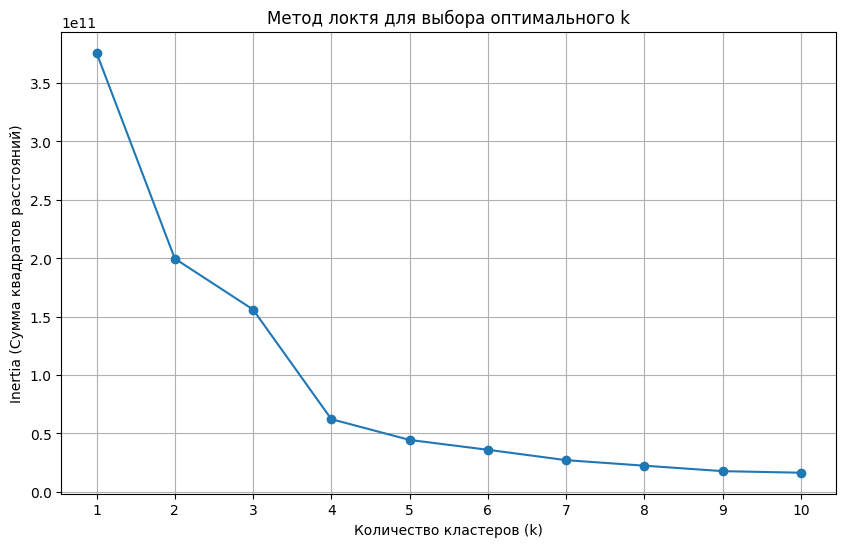

In [92]:
#  Метод локтя (Elbow Method)
from sklearn.cluster import KMeans
X = df[numeric_cols]

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# График метода локтя
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Inertia (Сумма квадратов расстояний)')
plt.title('Метод локтя для выбора оптимального k')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

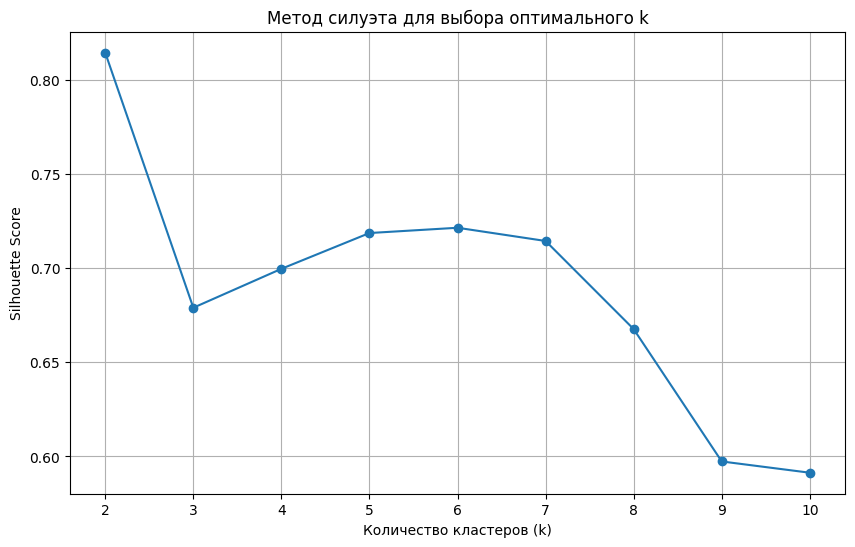

In [93]:
# 2. Метод силуэта (Silhouette Score)
#Чем выше значение, тем лучше кластеризация.

from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):  # Минимум 2 кластера
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# График силуэтного коэффициента
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('Метод силуэта для выбора оптимального k')
plt.xticks(range(2, 11))
plt.grid()
plt.show()

In [94]:
# Calinski-Harabasz Index
#Чем выше значение, тем лучше кластеризация.

from sklearn.metrics import calinski_harabasz_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = calinski_harabasz_score(X, labels)
    print(f"k={k}: Score = {score:.2f}")

k=2: Score = 278.05
k=3: Score = 221.26
k=4: Score = 526.41
k=5: Score = 582.49
k=6: Score = 588.01
k=7: Score = 665.70
k=8: Score = 698.46
k=9: Score = 780.41
k=10: Score = 751.31


In [95]:
kmeans = KMeans(n_clusters=3, random_state=42)  # Разделим на 3 группы
df['Cluster'] = kmeans.fit_predict(X)

# Добавляем колонку 'Cluster' в основной DataFrame df
df['Cluster'] = df['Cluster']

In [96]:
import plotly.express as px

# Создаем интерактивный график с заданными размерами
fig = px.scatter(df, 
                 x='Sharpe ratio', 
                 y='Net profit', 
                 color='Cluster', 
                 title='Кластеризация стратегий',
                 labels={'Cluster': 'Кластер'},
                 hover_data=['Percent profitable', 'Max equity drawdown', 'Total trades'])

# Устанавливаем размеры графика
fig.update_layout(width=800, height=600)  # Задайте нужные размеры в пикселях

# Обновляем внешний вид графика
fig.update_traces(
    marker=dict(
        size=12,
        opacity=0.8,
        line=dict(width=1, color='black')
    )
)
# Или задать свою палитру
fig.update_layout(coloraxis=dict(colorscale='Viridis'))

# Показываем график
fig.show()


In [97]:
df['Cluster'].value_counts()

Cluster
0    255
2     46
1     16
Name: count, dtype: int64

In [98]:
group_data = df.groupby(by='Cluster')[['Sharpe ratio', 'Net profit']].mean()

group_data

,Sharpe ratio,Net profit
Cluster,,
0,-0.127545,2517.172627
1,0.101000,100218.456250
2,0.139196,35318.447174


Проведем кластерный анализ для выявления паттернов.

Оптимальное количество кластеров для анализа стратегий — 3. Это позволяет разделить стратегии на:

Высокодоходные с низким риском (лучшие).

Средние по доходности и риску.

Низкодоходные или высокорисковые (худшие).

# Взвешивание показателей

Не все показатели одинаково важны. Например, Sharpe Ratio и Max Drawdown важнее в нашем случае, чем Total Trades.

Сделать только кластеры = 0

In [99]:
import pandas as pd
import re
from typing import Dict, List

def add_tag_columns_efficient(df: pd.DataFrame, tags: Dict[str, List[str]]) -> pd.DataFrame:
    """
    Эффективно добавляет колонки 'analysis_Method' и 'indicators' в датафрейм,
    проверяя только 'title', 'strategy_description' и 'tags'.
    
    Args:
        df: Исходный DataFrame
        tags: Словарь с категориями тегов
        
    Returns:
        Модифицированный DataFrame с двумя новыми колонками
    """
    # Подготовка регулярных выражений один раз
    patterns = {
        'analysis_Method': re.compile(r'(?<!\w)(' + '|'.join(map(re.escape, tags['analysis_Method'])) + r')(?!\w)', 
                                    flags=re.IGNORECASE),
        'indicators': re.compile(r'(?<!\w)(' + '|'.join(map(re.escape, tags['indicators'])) + r')(?!\w)', 
                              flags=re.IGNORECASE)
    }
    
    # Кэшируем нужные колонки для быстрого доступа
    title_vals = df['title'].astype(str)
    desc_vals = df['strategy_description'].astype(str)
    tags_vals = df['tags'].astype(str)
    
    # Функция для поиска уникальных совпадений
    def find_unique_matches(row: pd.Series, pattern: re.Pattern) -> str:
        combined_text = f"{row['title']} {row['strategy_description']} {row['tags']}".lower()
        matches = set(pattern.findall(combined_text))
        return ', '.join(matches) if matches else ''
    
    # Применяем только к нужным колонкам
    df['analysis_method'] = df.apply(find_unique_matches, pattern=patterns['analysis_Method'], axis=1)
    df['indicators'] = df.apply(find_unique_matches, pattern=patterns['indicators'], axis=1)
    
    return df

# Пример использования:
df = add_tag_columns_efficient(df, tags)

In [100]:
df.replace(["", " ", "-"], pd.NA, inplace=True)
df_cl = df.dropna(subset=['indicators', 'analysis_method'], how='all')

In [101]:
df_best = df_cl[df_cl['Cluster']==1]

In [102]:
# Задаём веса (сумма = 1)
weights = {
    'Net profit': 0.3,
    'Sharpe ratio': 0.3,  # Чем выше, тем лучше
    'Percent profitable': 0.05,
    'Ratio avg win / avg loss': 0.05,
    'Max equity drawdown': 0.1,  # Чем меньше просадка, тем лучше → можно инвертировать
    'Total trades': 0.2   # Чем больше сделок, тем надёжнее статистика
}

# Инвертируем Max Drawdown (меньше просадка → выше оценка)
df_best['Max equity drawdown'] = 1 - df_best['Max equity drawdown']

# Рассчитываем общий рейтинг
df_best['Score'] = (
    df_best['Net profit'] * weights['Net profit'] +
    df_best['Sharpe ratio'] * weights['Sharpe ratio'] +
    df_best['Percent profitable'] * weights['Percent profitable'] +
    df_best['Ratio avg win / avg loss'] * weights['Ratio avg win / avg loss'] +
    df_best['Max equity drawdown'] * weights['Max equity drawdown'] +
    df_best['Total trades'] * weights['Total trades']
)

# Сортируем по убыванию рейтинга
best_strategies = df_best.sort_values('Score', ascending=False)
best_strategies

C:\Users\xndrf\AppData\Local\Temp\ipykernel_1888\2785380479.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\xndrf\AppData\Local\Temp\ipykernel_1888\2785380479.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,title,strategy_description,tags,Open P&L,Net profit,Gross profit,Gross loss,Commission paid,Buy & hold return,Max equity run-up,...,Profit factor,Margin calls,properties,classification,combined,type_tags,Cluster,analysis_method,indicators,Score
493,tasc 202410 adaptive oscillator threshold,overviewthis script introduces a more dynamic ...,centered oscillators relative strength index r...,0,121812.73,"429,996.21","308,183.48",0,"+11,537,854.20","141,726.01",...,1.395,0.0,"{'Trading range': 'Mar 08, 1993 — Sep 16, 2024...",combined strategy,overviewthis script introduces a more dynamic ...,[equity],1,indicator,"rsi, oscillator",33854.575370
136,zscore normalized vix strategy,this strategy leverages the concept of the zsc...,educational portfolio management volatility,0,111363.80,"361,624.50","250,260.70",48.70,"+172,137.50","117,403.00",...,1.445,0.0,"{'Trading range': 'Aug 17, 2006 — Apr 04, 2025...",combined strategy,this strategy leverages the concept of the zsc...,[],1,<NA>,distribution,31561.756130
789,equity curve trading with ema,what is equity curve tradingin equity curve tr...,moving averages,+357.00,113231.00,"256,865.00","143,634.00",0,"+2,961,415.52","120,251.00",...,1.788,0.0,"{'Trading range': 'Jan 06, 2014, 11:00 — Jun 0...",combined strategy,what is equity curve tradingin equity curve tr...,[equity],1,<NA>,"sma, supertrend, ema",31336.606140
909,1226it strategy,base of this strategy is crossover of 12ema on...,educational pivot points and levels double exp...,0,114864.50,"321,245.90","206,381.40",0,"+5,357,422.70","118,560.85",...,1.557,0.0,"{'Trading range': 'Apr 06, 1999 — Jan 04, 2023...",combined strategy,base of this strategy is crossover of 12ema on...,[],1,indicator,"macd, rsi",30759.988255
159,strategy stats presenttrading,hello its another weekend this tool is a strat...,statistical sortino educational strategy backt...,+755.64,102593.39,"209,368.33","106,774.94","6,128.41","+3,605,261.53","112,259.81",...,1.961,0.0,"{'Trading range': 'Apr 09, 2013, 18:00 — Apr 0...",combined strategy,hello its another weekend this tool is a strat...,"[equity, crypto, currency]",1,atr,"atr, supertrend",29249.323570
6,1h liquidity swings strategy with 12 rr,luxalgo liquidity swings simulateduses tapivot...,breadth indicators,"−1,160.00",117390.00,"859,610.00","742,220.00",0,"+708,340.00","155,735.00",...,1.158,0.0,"{'Trading range': 'Jan 04, 2023, 14:00 — May 0...",combined strategy,luxalgo liquidity swings simulateduses tapivot...,[],1,"supportresistance, liquidity, volume","sma, breadth",29203.231585
793,hobbiecode five day low rsi strategy,this is a simple strategy that is working well...,tradingalgoritmico algorithmictrading strategy...,0,107287.50,"317,212.50","209,925.00",0,0,"110,250.00",...,1.511,0.0,"{'Trading range': 'Sep 26, 1997 — May 25, 2023...",combined strategy,this is a simple strategy that is working well...,[future],1,candlestick,rsi,28940.461925
453,chande momentum oscillator strategy,the chande momentum oscillator cmo trading str...,regressions sentiment oscillators,0,104137.50,"234,325.00","130,187.50",0,"+2,876,737.50","106,125.00",...,1.800,0.0,"{'Trading range': 'Oct 20, 1997 — Oct 17, 2024...",combined strategy,the chande momentum oscillator cmo trading str...,[],1,"indicator, technical","rsi, oscillator",27955.680640
809,supertrend long strategy trendfilter,this strategy aims to identify long buy opport...,cycles supertrend long trend trend analysis fo...,−538.03,99083.31,"365,009.64","265,926.33",0,"−17,683.38","129,865.77",...,1.373,0.0,"{'Trading range': 'Jan 06, 2021, 22:00 — May 0...",combined strategy,this strategy aims to identify long buy opport...,[],1,"indicator, atr","sma, atr, supertrend",27304.623645
929,bollinger band strategy with split limit stop,entering a short position after breaking the u...,limit position bands and channels stoploss bol...,0,101177.12,"512,453.05","411,275.93","17,502.93","−637,545.72","123,279.31",...,1.246,0.0,"{'Trading range': 'Jan 02, 2022, 02:00 — Dec

In [103]:
df_bad = df_cl[df_cl['Cluster']==0]

display(df_bad.head(10))

,title,strategy_description,tags,Open P&L,Net profit,Gross profit,Gross loss,Commission paid,Buy & hold return,Max equity run-up,...,Sortino ratio,Profit factor,Margin calls,properties,classification,combined,type_tags,Cluster,analysis_method,indicators
2,exodus,exodus by dafe trading systemsexodus is a soph...,volume volatility oscillators,0,14293.23,"68,836.40","54,543.18","1,672.77","+5,593,815.28","20,726.51",...,-0.782,1.262,0.0,"{'Trading range': 'Jan 30, 2020, 11:00 — May 0...",combined strategy,exodus by dafe trading systemsexodus is a soph...,[future],0,"earnings, atr, volume","adx, sma, atr, ema"
10,parabolic rsi strategy ma filter tpsl pakunfx,parabolic rsi strategy ma filter tpslpakunfxth...,exponential moving average ema strategy strate...,0,29.75,99.62,69.87,4.81,−442.20,39.31,...,-0.236,1.426,0.0,"{'Trading range': 'Sep 30, 2024, 10:50 — May 0...",combined strategy,parabolic rsi strategy ma filter tpslpakunfxth...,"[forex, fx]",0,indicator,"sma, rsi, ma, sar, ema"
13,ut bot strategy backtest with date range,backtesting strategy for ut bot alerts by quan...,portfolio management educational strategy stat...,−0.04,-31.28,364.15,395.43,0,−4.21,55.25,...,-0.140,0.921,0.0,"{'Trading range': 'Apr 01, 2025, 19:05 — May 0...",combined strategy,backtesting strategy for ut bot alerts by quan...,[equity],0,atr,atr
17,bb 202 rsi10 stoch 1433 5min,on the 1minute chart using the indicators stoc...,options pine utilities bands and channels,−183.40,8562.03,"29,730.87","21,168.84",0,"+144,746.73","11,117.67",...,1.040,1.404,0.0,"{'Trading range': 'Apr 20, 2025, 19:02 — May 0...",indicators,on the 1minute chart using the indicators stoc...,[],0,<NA>,"stochastic, bollinger, ma"
20,powerhouse swiftedge ai v210 strategy,overviewthe powerhouse swiftedge ai v210 strat...,trend analysis exponential moving average ema,0,635.90,"2,222.20","1,586.30",0,"+54,663.93",707.70,...,0.228,1.401,0.0,"{'Trading range': 'Apr 21, 2025, 02:55 — Apr 3...",combined strategy,overviewthe powerhouse swiftedge ai v210 strat...,"[future, crypto, forex]",0,"atr, volume, vwap, cvd, technical","atr, ema"
21,bollinger ema strategy with stats,sharpe_window inputint252 sharpe lookbacksharp...,bands and channels,0,4829.83,"20,508.27","15,678.44",1.28,−29.20,"5,743.05",...,0.208,1.308,0.0,"{'Trading range': 'Aug 18, 2023, 13:00 — Apr 3...",No classification,sharpe_window inputint252 sharpe lookbacksharp...,[],0,<NA>,"bollinger, ema"
24,chopflow atr scalp strategy,a lean highvelocity scalp framework for nq and...,average true range atr scalping on balance vol...,0,19704.73,"365,501.08","345,796.35","2,214.27","+217,775.00","20,786.64",...,-0.735,1.057,0.0,"{'Trading range': 'May 02, 2021, 19:00 — Apr 3...",combined strategy,a lean highvelocity scalp framework for nq and...,[future],0,"obv, atr, priceaction, volume","sma, obv, atr, ma"
28,ddddd ebp strategy improved with atr filters l...,ddddd ebp strategy improved with atr filters l...,chart patterns exponential moving average ema ...,−2.43,347.10,"1,238.78",891.68,0,"+1,819.27",352.95,...,0.089,1.389,0.0,"{'Trading range': 'Jan 07, 1975 — Apr 30, 2025...",combined strategy,ddddd ebp strategy improved with atr filters l...,[],0,"atr, engulfing","atr, ema"
34,nexus trade bot,the nexus trade bot is a sophisticated trading...,trend analysis,0,5107.50,"9,928.00","4,820.50",0,"−44,112.00","5,845.50",...,0.304,2.060,0.0,"{'Trading range': 'Mar 04, 2025, 00:05 — Apr 2...",combined strategy,the nexus trade bot is a sophisticated trading...,"[future, crypto, forex]",0,<NA>,"sma, roc, ema"
38,supertrade ichimoku cloud strategy,unlike supertrades super trend the ichimoku cl...,volume pine utilities chart patterns,"+2,726.96",3699.80,"105,714.58","102,014.78",0,"−131,557.47","21,851.11",...,-0.742,1.036,0.0,"{'Trading range': 'Jan 19, 2012, 10:00 — Apr 2...",combined strategy,unlike supertrades super trend the ichimoku cl...,[],0,"indicator, volume, supportresistance",ichimoku


In [104]:
best_strategies['title'].to_excel('Strategy.xlsx', index=False)